<br><br>
<p style="font-size:24px; color:#216594;text-align:center;">
Applied AI in Chemical and Process Engineering
</p>

<p style="font-size:30px; color:black;text-align:center;">
    Bulding ML pipeline for Reactor data
</p>


███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
<br>


**Week 3-4**

This notebook will build a pipeline to prepare data and develop an ML algorithm


# Content

**Part 1: Data Preprocessing & Exploration**

| Step                  | Description                                                                 | Key Actions & Tools                                                                                     |
|-----------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **Data Preparation**  | Gather, load, and inspect raw data                                          | - Load dataset (e.g., CSV, DB)<br>- Check data types, shape, initial samples (`df.head()`, `df.info()`) |
| **Data Cleaning**     | Fix issues in data quality                                                  | - Handle missing values (impute or drop)<br>- Remove duplicates<br>- Detect and treat outliers (IQR, Z-score) |
| **Exploratory Data Analysis (EDA)** | Understand data distributions and relationships                   | - Visualizations: histograms, scatter plots, pair plots<br>- Correlation matrix (heatmaps)<br>- Summary statistics |

**Part 2: Modeling & Interpretation**

| Step                                  | Description                                                                 | Key Actions & Tools                                                                                     |
|---------------------------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **Normalization (Principle Only)**    | Scale features to same range (e.g., for distance-based models)              | - Apply Min-Max Scaling or Standardization<br>- Justify choice based on model needs (e.g., SVM, KNN, Neural Networks) |
| **Model Training, Validation & Testing** | Build and evaluate model performance                                    | - Split data: `train_test_split`<br>- Train models (e.g., Linear Regression, Random Forest, XGBoost)<br>- Use cross-validation<br>- Evaluate using metrics (RMSE, MAE, R², etc.) |
| **Model Explanation with XAI**        | Interpret model predictions and feature importance                          | - Use SHAP, LIME, or feature importance plots<br>- Explain predictions to stakeholders<br>- Ensure transparency and trust |

**Note:** Since our example does not have categorical data, we do not encode variables - which is essential if the data is categorical

# Ethanol Production - Sugar Industry

![Process Flow Diagram](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/etoh_flowdiagram.png?raw=1)


**Our goal is to model residual sugar. The model can be later used to optimize the fermentation process**

**Data**
- Temperature °C: Fermentation tank
- pH: Fermentation tank
- Yeast Concentration g/L: Fermentation tank
- Sugar Concentration w/v: Dilution tank (input for fermenation)
- Residual Sugar g/L: Post-fermentation


Note: The data is simualted data


In [ ]:
# Load all the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.optimize import minimize
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler

# Data Preperation

**Prompt:**
Load data from below github
https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv')

**Prompt:**

Print first 15 rows of the table and the dimensions of the table

In [ ]:
# Print first 15 rows of the table
print("First 15 rows of the table:")
df.head(15)


First 15 rows of the table:


,Temperature,pH,Yeast_Concentration,Sugar_Concentration,Residual_Sugar
0,28.7,5.0,1.2,12.3,5.3
1,34.5,5.4,2.3,10.0,5.4
2,32.3,5.1,4.1,17.3,3.2
3,31.0,4.3,3.8,19.7,2.7
4,26.6,4.0,4.2,12.2,5.5
5,26.6,4.4,3.1,16.6,5.2
6,25.6,4.9,2.8,17.4,5.2
7,33.7,4.1,1.6,18.5,7.6
8,31.0,4.7,2.3,14.2,5.1
9,32.1,4.9,2.7,13.0,3.9


In [ ]:
# Print the shape of the table
print("Shape of the table (rows, columns):")
print(df.shape)

Shape of the table (rows, columns):
(972, 5)


# Data Cleaning

| Step           | Purpose                                      | Common Methods                                                                 | Notes                                                                 |
|----------------|----------------------------------------------|---------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **Missing Data** | Handle incomplete or null values             | - Remove rows/columns<br>- Impute with mean/median/mode<br>- KNN/imputation models | Can bias models; choice depends on amount and reason for missingness |
| **Duplicates**   | Remove redundant data entries                | - Identify and drop duplicate rows<br>- Use `pandas.drop_duplicates()`           | Prevents overfitting and skewed results                              |
| **Outliers**     | Detect and manage extreme values             | - Z-score, IQR method<br>- Visualization (box plots, scatter plots)<br>- Winsorizing | Can distort models; keep if meaningful (e.g., fraud detection)       |

## Check for missing data

**Prompt:**
Check if the table has missing values

In [ ]:
# Check for missing values in the entire DataFrame
print("Total number of missing values in the table:")
print(df.isnull().sum().sum())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSummary: Does the table have any missing values?")
print(df.isnull().values.any())

Total number of missing values in the table:
2

Missing values per column:
Temperature            0
pH                     0
Yeast_Concentration    0
Sugar_Concentration    2
Residual_Sugar         0
dtype: int64

Summary: Does the table have any missing values?
True


## Fill the missing data wiht median using imputer

**Prompt:**
Fill the missing data with median value

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Identify numeric columns with missing values
# From your data: Sugar_Concentration and Ethanol_Yield have 2 missing values each
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create a SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit and transform the numeric columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Verify that all missing values are filled
print("Missing values after imputation:")
print(df.isnull().sum())

print(f"\nImputation completed using median values.")

Missing values after imputation:
Temperature            0
pH                     0
Yeast_Concentration    0
Sugar_Concentration    0
Residual_Sugar         0
dtype: int64

Imputation completed using median values.


## Check for duplicates

**Prompt:**

Check if it has duplicates

In [ ]:
# Check for duplicate rows
print("Number of duplicate rows in the DataFrame:")
print(df.duplicated().sum())

print("\nWhich rows are duplicates?")
print(df[df.duplicated()])

Number of duplicate rows in the DataFrame:
0

Which rows are duplicates?
Empty DataFrame
Columns: [Temperature, pH, Yeast_Concentration, Sugar_Concentration, Residual_Sugar]
Index: []


# Exploratory Dara Analysis (EDA)

## Summary Stats

**Prompt:**

In [ ]:
df.describe()

,Temperature,pH,Yeast_Concentration,Sugar_Concentration,Residual_Sugar
count,972.000000,972.000000,972.000000,972.000000,972.000000
mean,30.003807,4.760802,2.982510,14.961934,5.155041
std,3.649713,0.484015,1.160695,2.852478,1.510385
min,25.000000,0.100000,1.000000,10.000000,0.800000
25%,27.375000,4.400000,2.000000,12.500000,4.100000
50%,30.000000,4.800000,3.000000,14.950000,5.200000
75%,32.500000,5.100000,4.000000,17.400000,6.100000
max,82.000000,9.000000,5.000000,20.000000,10.900000


## Data Visualization

### Data Visualization with Box Plot


![Box plot](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/boxplot.png?raw=1)


**Prompt:**

Create box plots for all variables in multiple plots in single figure. show outliers

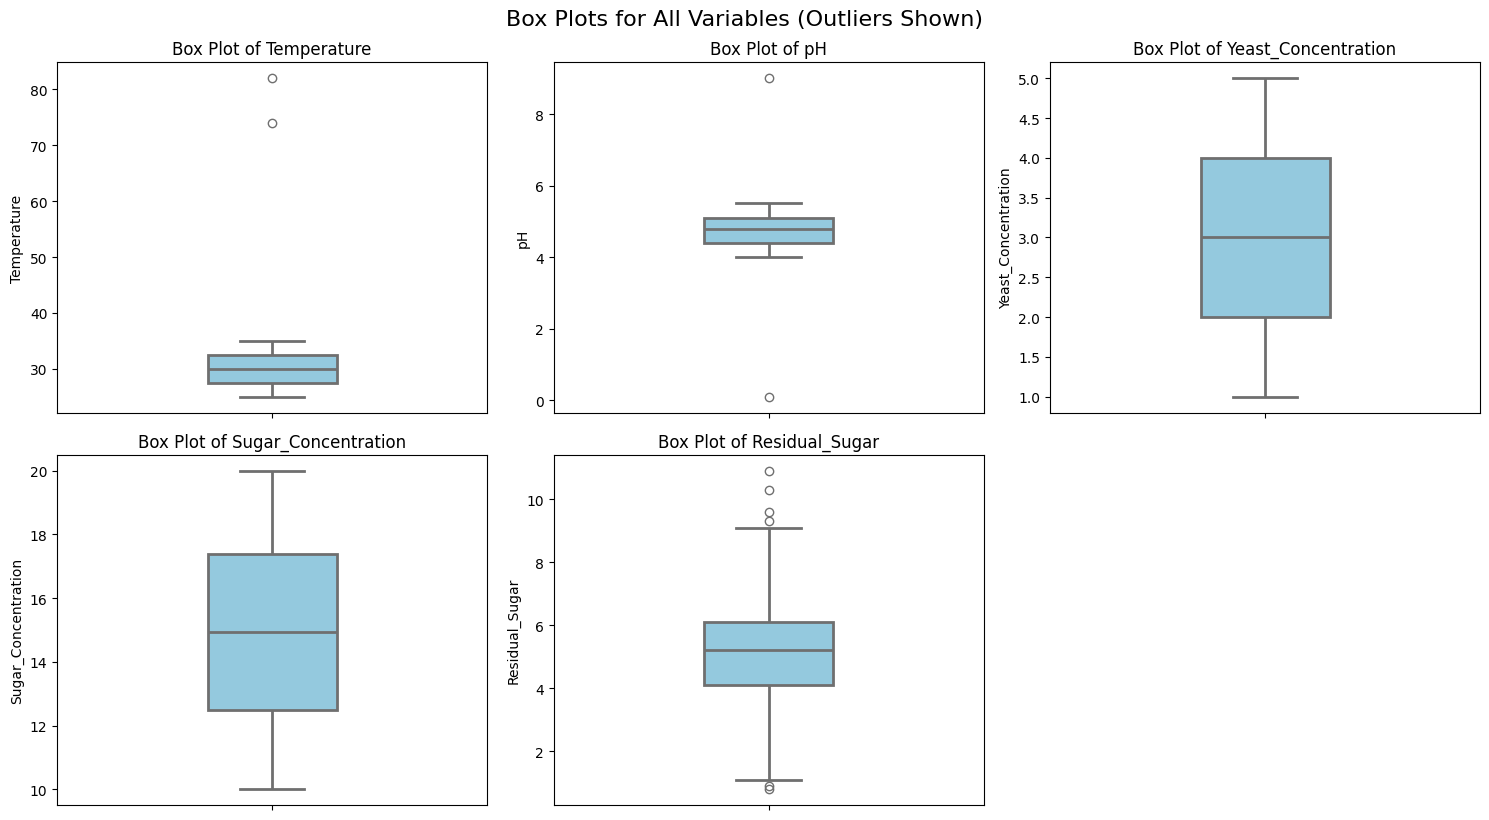

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot grid (adjust layout based on number of variables)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Adjust rows to have up to 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of multiple rows

# Create a box plot for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue', fliersize=6, linewidth=2, width=.3)
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Box Plots for All Variables (Outliers Shown)', fontsize=16, y=1.02)
plt.show()

### Data Visualization with Violine plot


![Violin plot](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/violinplot.png?raw=1)


**Prompt:**

Create violine plots for all variables in multiple plots in single figure.

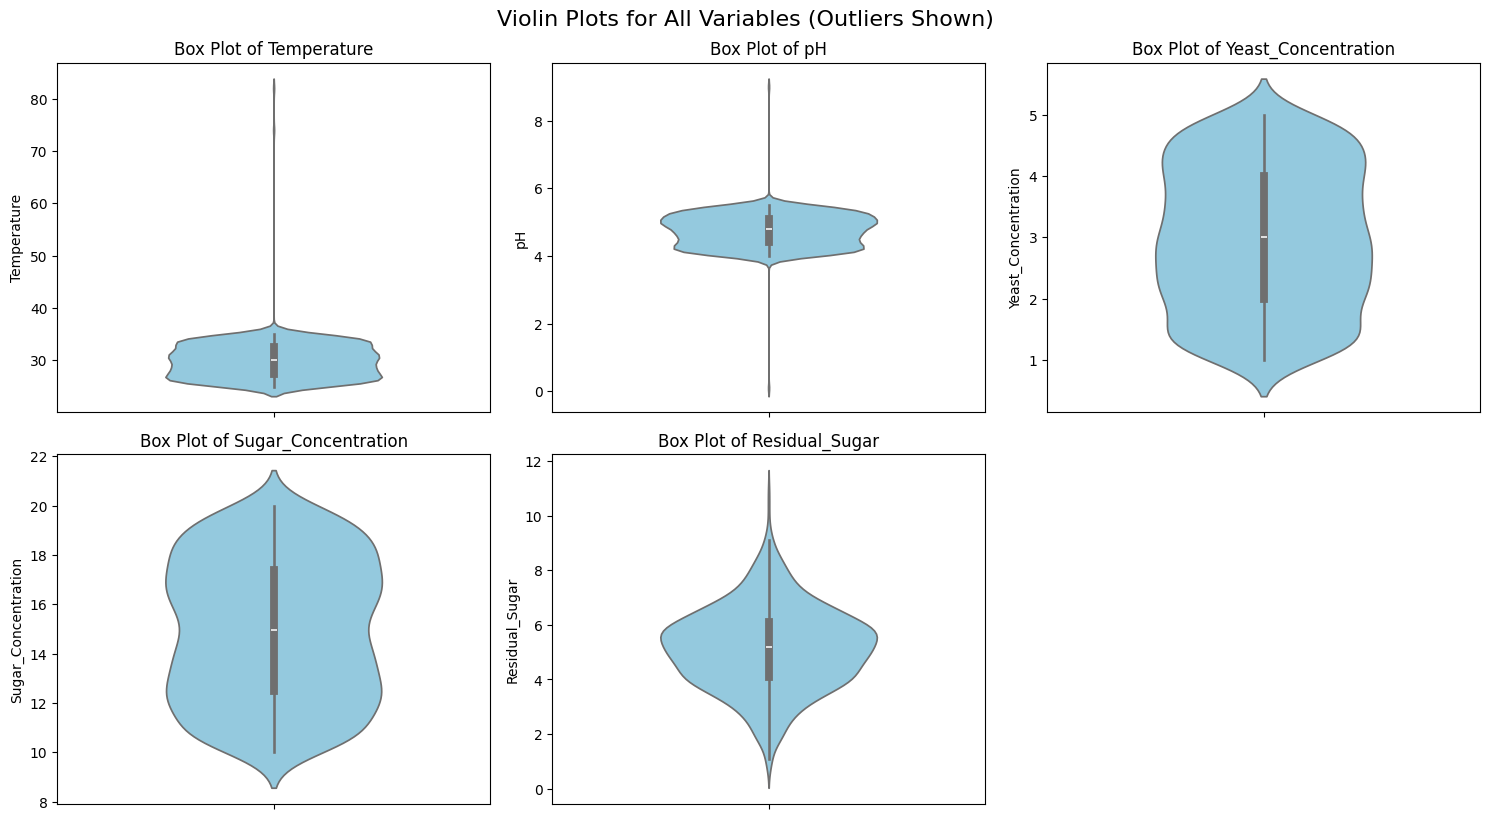

In [ ]:
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Adjust rows to have up to 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of multiple rows

# Create a box plot for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.violinplot(y=df[col], ax=axes[i], color='skyblue', width=.5)
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Violin Plots for All Variables (Outliers Shown)', fontsize=16, y=1.02)
plt.show()

### Data Visualization with Histogram plot

**Prompt:**

Create histogram plots for all variables in multiple plots in single figure.

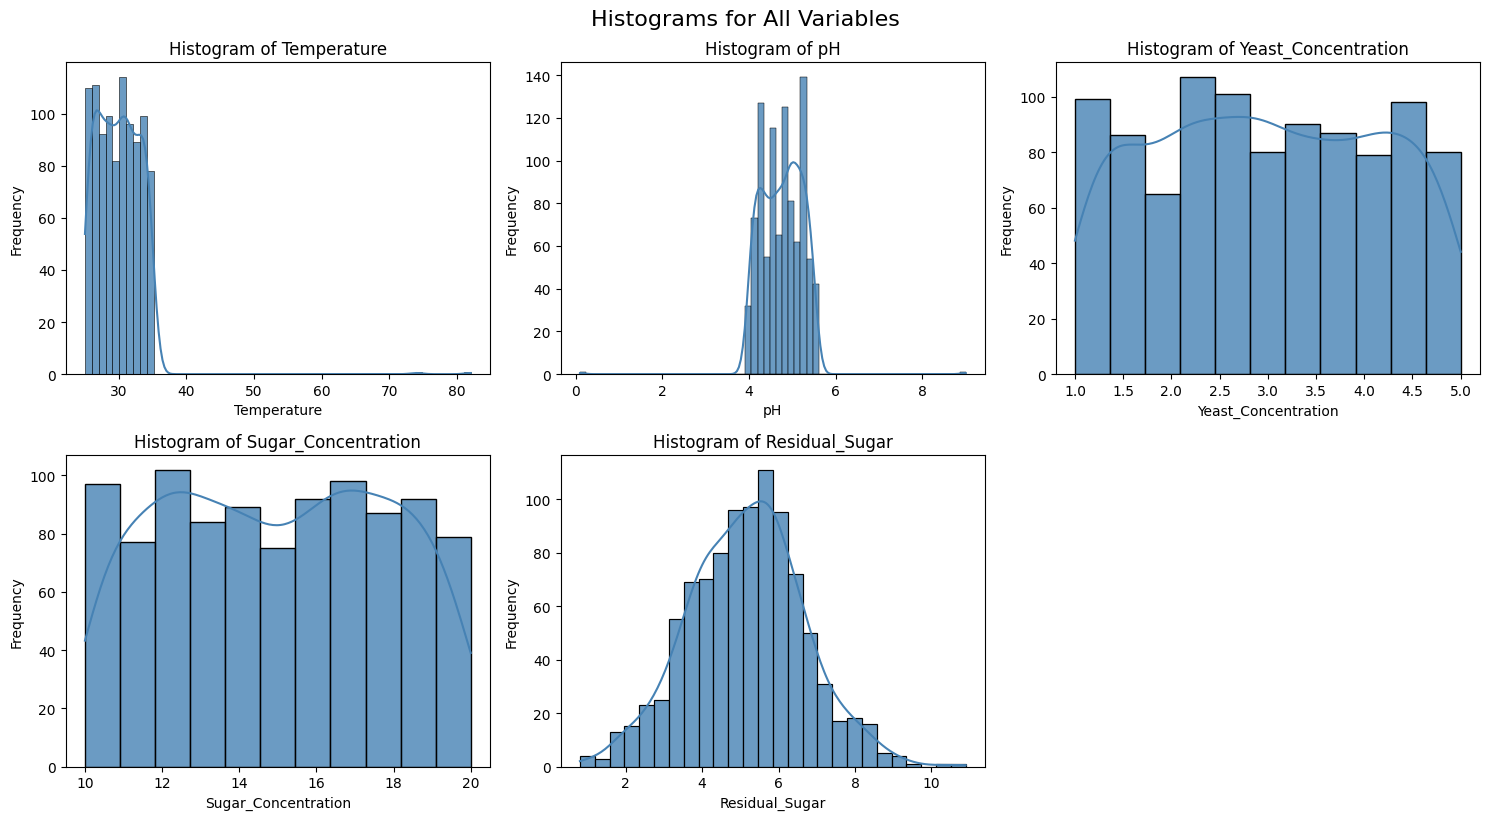

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot grid (e.g., 3 plots per row)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Ceiling division to get number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot histogram for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='steelblue', alpha=0.8)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms for All Variables', fontsize=16, y=1.02)
plt.show()

## Outliers

**Strategy:** We will use statistical methods to remove outliers (IQR)

**Prompt:**

Remove all outliers of df using IQR method and create a table called dfclean

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Select only numeric columns from df
df_numeric = df.select_dtypes(include=[np.number])

# Step 2: Define function to remove outliers using IQR
def remove_outliers_iqr(df, factor=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    # Create a mask for non-outlier values
    mask = (df >= lower_bound) & (df <= upper_bound)
    # Keep only rows where all columns are within bounds
    return df[mask.all(axis=1)]

# Step 3: Apply IQR method and create dfclean
dfclean = remove_outliers_iqr(df_numeric)

# Step 4: Optional – Reset index for cleanliness
dfclean = dfclean.reset_index(drop=True)

# Step 5: Print summary
print(f"Original DataFrame (numeric rows): {df_numeric.shape[0]}")
print(f"Cleaned DataFrame (dfclean): {dfclean.shape[0]}")
print(f"Outliers removed: {df_numeric.shape[0] - dfclean.shape[0]} rows")
print(f"Reduction: {((df_numeric.shape[0] - dfclean.shape[0]) / df_numeric.shape[0] * 100):.2f}%")

Original DataFrame (numeric rows): 972
Cleaned DataFrame (dfclean): 964
Outliers removed: 8 rows
Reduction: 0.82%


### Histogram plot with cleaned data

**Prompt:**

Create histogram plots for all variables in multiple plots in single figure using dfclean

Text(0.5, 1.02, 'Histograms for All Variables (dfclean - Outliers Removed)')

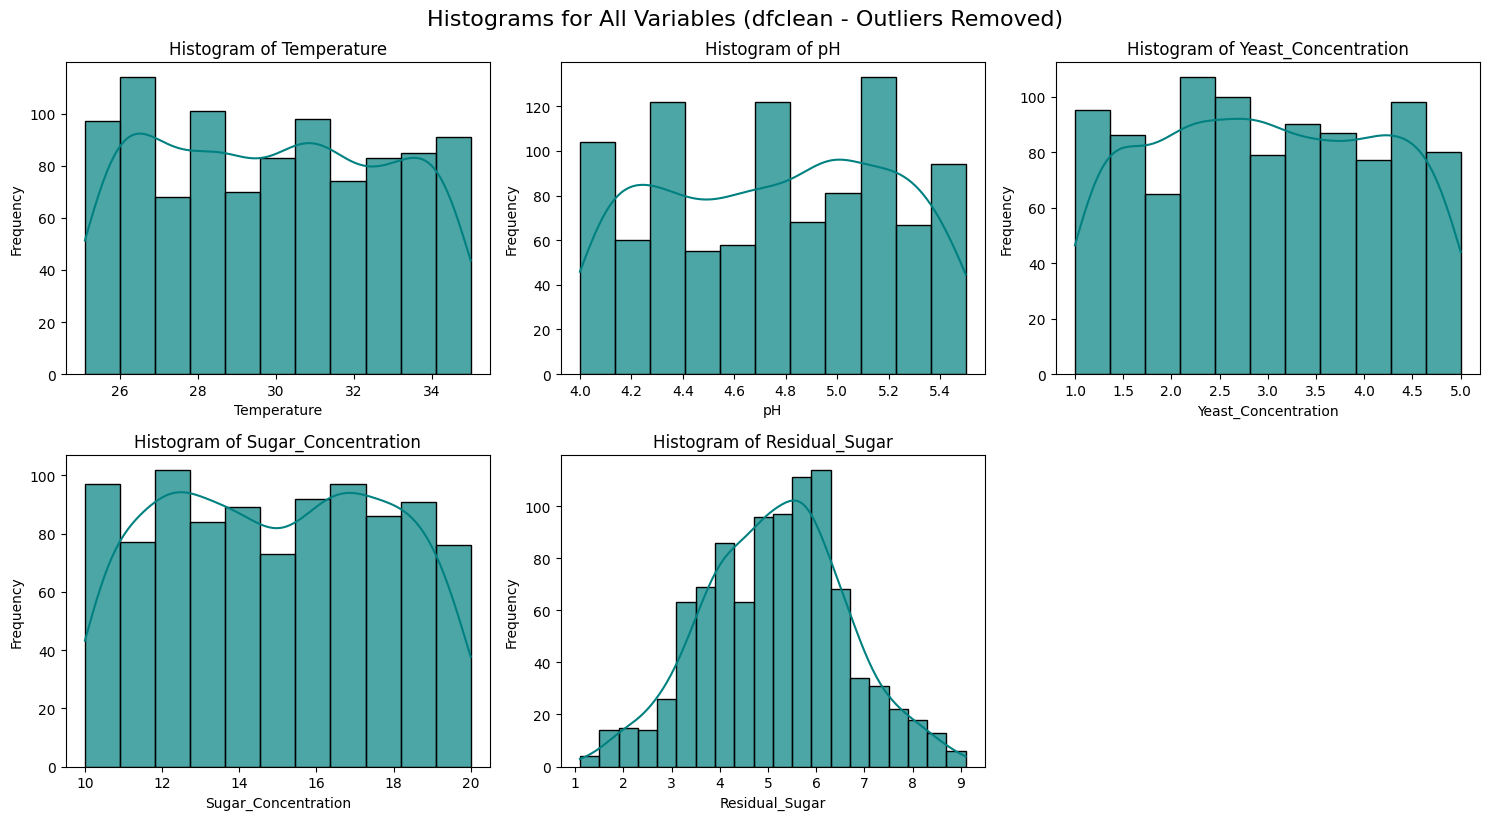

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric columns from dfclean (safe if mixed types)
numeric_cols = dfclean.select_dtypes(include=[np.number]).columns

# Set up the subplot grid (e.g., 3 plots per row)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Ceiling division to determine number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten for easy indexing

# Plot histogram for each numeric column in dfclean
for i, col in enumerate(numeric_cols):
    sns.histplot(dfclean[col], ax=axes[i], kde=True, color='teal', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots (if total plots > number of variables)
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms for All Variables (dfclean - Outliers Removed)', fontsize=16, y=1.02)

## Corelinearity

**Prompt:**

Print correlations matrix and do a plot a heatmap of correlation of dfclean

=== Correlation Matrix ===
                     Temperature        pH  Yeast_Concentration  \
Temperature             1.000000 -0.012451            -0.008779   
pH                     -0.012451  1.000000             0.015833   
Yeast_Concentration    -0.008779  0.015833             1.000000   
Sugar_Concentration    -0.014722  0.003738             0.006277   
Residual_Sugar         -0.011687 -0.026576            -0.510320   

                     Sugar_Concentration  Residual_Sugar  
Temperature                    -0.014722       -0.011687  
pH                              0.003738       -0.026576  
Yeast_Concentration             0.006277       -0.510320  
Sugar_Concentration             1.000000        0.102366  
Residual_Sugar                  0.102366        1.000000  


<Axes: >

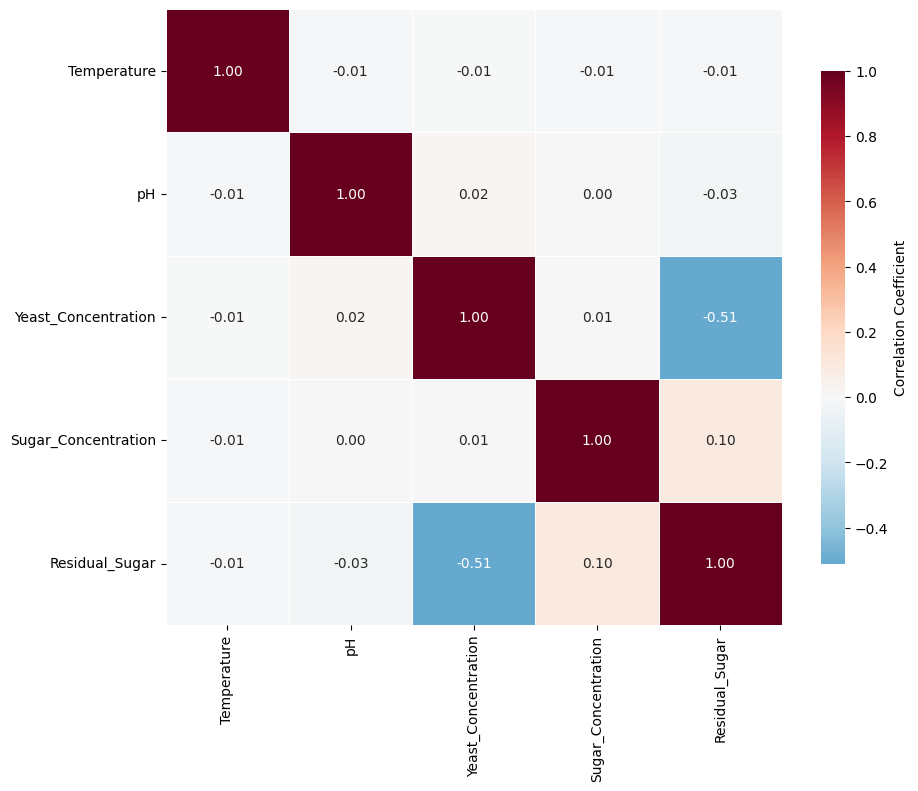

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure only numeric columns are used
df_numeric = dfclean.select_dtypes(include=[float, int])

# Step 1: Compute and print the correlation matrix
print("=== Correlation Matrix ===")
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

# Step 2: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show correlation values on the map
    cmap='RdBu_r',        # Red-Blue diverging colormap (good for -1 to 1)
    center=0,             # Center the colormap at zero
    square=True,          # Make cells appear square
    fmt='.2f',            # Format numbers to 2 decimal places
    linewidths=0.5,       # Add thin lines between cells
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

# Customize

# Data Prep for Model

## Define Features and Target

**Prompt:**

'Residual_Sugar' is Y variables and Temperature','pH','Yeast_Concentration','Sugar_Concentration' are features. Plot scatter plot between features and Y

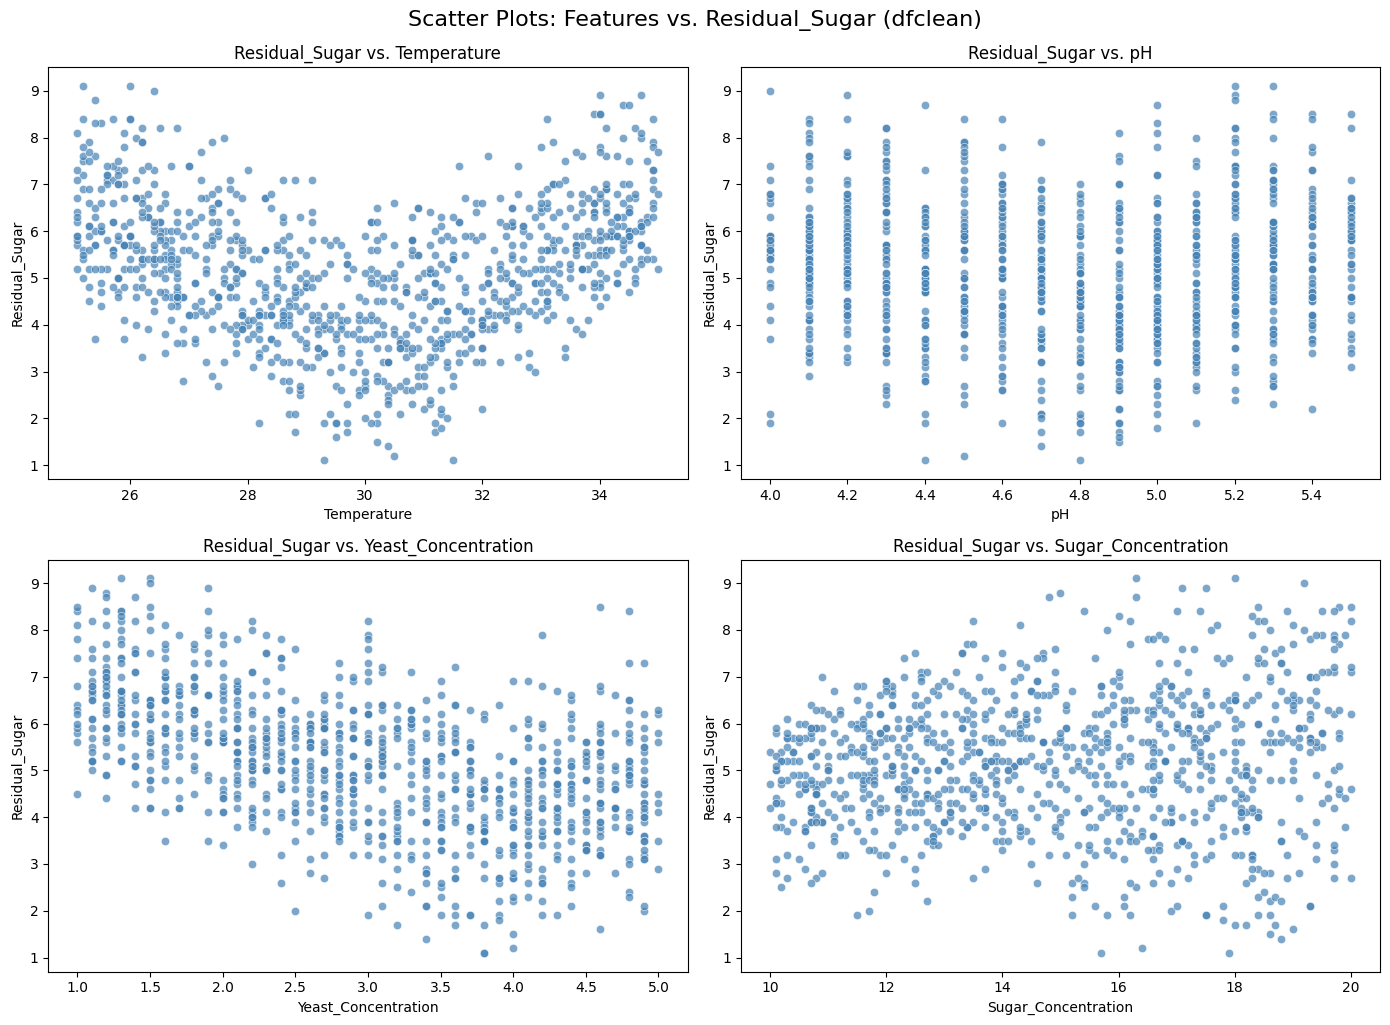

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define features and target
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
target = 'Residual_Sugar'

# Select data from dfclean (assumed to be your cleaned DataFrame)
df_plot = dfclean  # Ensure dfclean is defined

# Set up the subplot: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Plot each feature vs. Residual_Sugar
for i, col in enumerate(features):
    sns.scatterplot(x=df_plot[col], y=df_plot[target], ax=axes[i], alpha=0.7, color='steelblue')
    axes[i].set_title(f'{target} vs. {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel(target, fontsize=10)

# Optional: Add a trend line (regression line) to each plot
# Uncomment the loop below if you want trend lines
"""
for i, col in enumerate(features):
    sns.regplot(x=df_plot[col], y=df_plot[target], ax=axes[i],
                scatter=False, color='red', line_kws={'linewidth': 1.5})
"""

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Scatter Plots: Features vs. Residual_Sugar (dfclean)', fontsize=16, y=1.02)
plt.show()

## Feature Engineering with Data Scaling

**Prompt:**

Normalize X data using StandarScaler and plot histogram

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define features and target
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
target = 'Residual_Sugar'

# Extract X (features) and y (target)
X = dfclean[features]
Y = dfclean[target]  # Not scaled (target)

# Initialize and apply StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled X back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("✅ X has been normalized using StandardScaler.")
print("   Each feature now has mean ≈ 0 and standard deviation ≈ 1.")
print(X_scaled_df.describe())

✅ X has been normalized using StandardScaler.
   Each feature now has mean ≈ 0 and standard deviation ≈ 1.
        Temperature            pH  Yeast_Concentration  Sugar_Concentration
count  9.640000e+02  9.640000e+02         9.640000e+02         9.640000e+02
mean   3.427410e-16 -9.379312e-16        -3.685388e-17         5.491228e-16
std    1.000519e+00  1.000519e+00         1.000519e+00         1.000519e+00
min   -1.649969e+00 -1.731078e+00        -1.717996e+00        -1.734952e+00
25%   -8.616246e-01 -8.205560e-01        -8.538888e-01        -8.567629e-01
50%    2.954690e-02  8.996600e-02         1.021870e-02        -1.370121e-02
75%    8.864426e-01  7.728575e-01         8.743262e-01         8.644881e-01
max    1.743338e+00  1.683380e+00         1.738434e+00         1.777805e+00


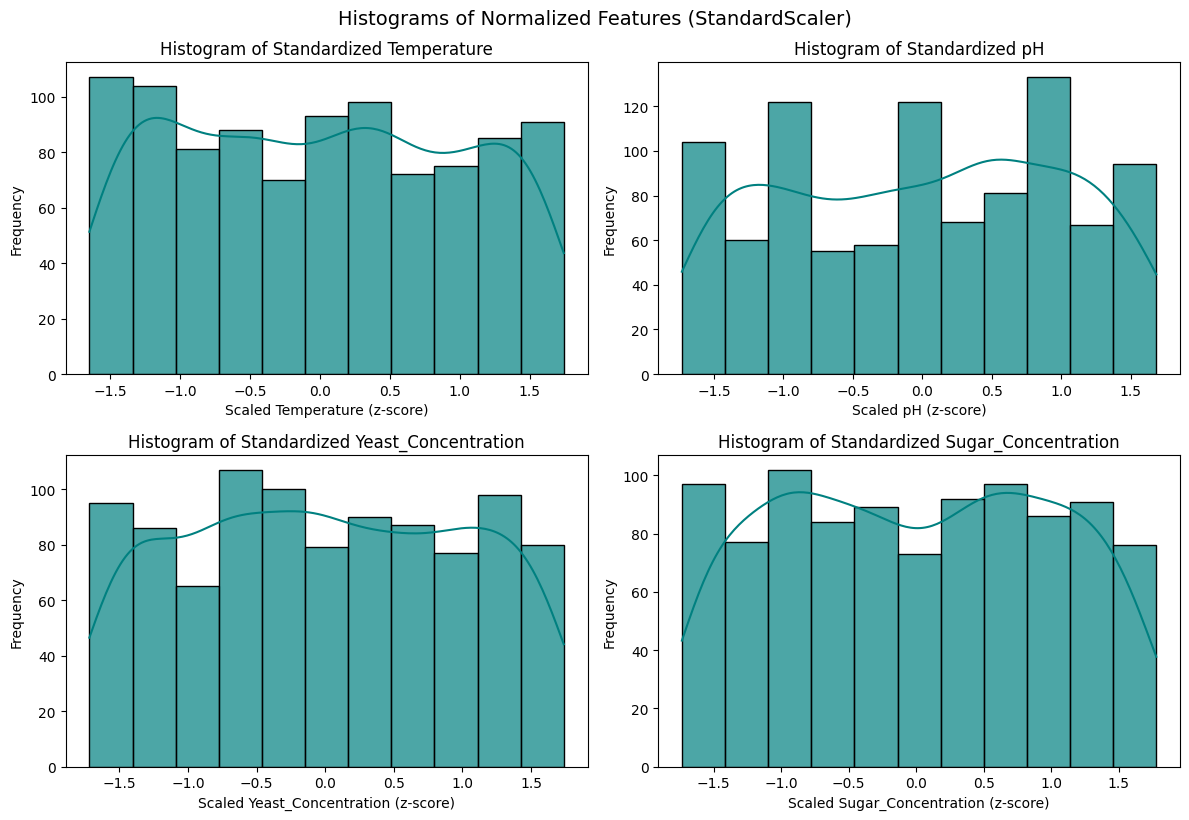

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subplot grid (2 rows, 2 columns for 4 features)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot histogram for each normalized feature
for i, col in enumerate(features):
    sns.histplot(X_scaled_df[col], ax=axes[i], kde=True, color='teal', alpha=0.7)
    axes[i].set_title(f'Histogram of Standardized {col}')
    axes[i].set_xlabel(f'Scaled {col} (z-score)')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots (if needed)
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.suptitle('Histograms of Normalized Features (StandardScaler)', fontsize=14, y=1.02)
plt.show()

# Model Selection


![Model guide](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/model_selection.png?raw=1)

# XGBoost Model


**Note:**

Since this is tree model which does not require feature scaling in general, we **will not** use scaled data for model fitting


<p style="font-size:25px; color:blue;text-align:left;">
    XGBoost
</p>



    🔘 XGBoost is a machine learning algorithm that builds multiple decision trees one after another, where each new tree tries to fix the errors made by the previous trees.

    🔘 It uses a method called gradient boosting, which helps improve prediction accuracy by combining many weak models into a stronger one.
    
    🔘The algorithm includes features to prevent overfitting, such as regularization and controlling how the trees grow.

    🔘 XGBoost can handle large datasets efficiently by using parallel processing to speed up training.

    🔘 It is widely used because it is fast, accurate, and works well for tasks like classification and regression, making it popular among beginners and experts alike.

![xgboost](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/xgboost.png?raw=1)

References:

[XGboost paper](https://arxiv.org/abs/1603.02754)

## Data Split

![data split](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/datasplit.jpg?raw=1)

**Prompt**

Split the data into training and testing sets.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(f"Training set size: {len(Y_train)}")
print(f"Testing set size: {len(Y_test)}")

Training set size: 674
Testing set size: 290


## Hyperparameter Optimization
| Parameter             | Purpose                              | Simple Explanation | Default |
|-----------------------|--------------------------------------|--------------------|---------|
| `n_estimators`        | Number of decision trees             | More trees = more learning, but too many can overdo it. Like having more experts vote on the answer. <br> ✅ **Typical tuned range:** 100–300 | `100` |
| `max_depth`           | How deep each tree can go            | Controls complexity. Deeper = more detailed rules, but may memorize data. Like allowing more "if-then" steps. <br> ✅ **Typical tuned range:** 3–10 | `6` |
| `learning_rate`       | How fast the model learns            | Smaller = slow, steady improvement. Larger = fast but may overshoot. Like step size toward the goal. <br> ✅ **Typical tuned range:** 0.01 – 0.3 | `0.3` |
| `subsample`           | % of data used for each tree         | Uses only part of the data per tree to avoid overfitting. Like asking different small groups to learn. <br> ✅ **Typical tuned range:** 0.6 – 1.0 | `1.0` |
| `colsample_bytree`    | % of features used per tree          | Each tree uses only some columns (e.g., size, age, location). Prevents over-reliance on one feature. <br> ✅ **Typical tuned range:** 0.6 – 1.0 | `1.0` |
| `min_child_weight`    | Minimum data in a prediction box     | Stops trees from splitting too small. “Don’t make a rule unless at least a few examples agree.” <br> ✅ **Typical tuned range:** 1 – 7 | `1` |
| `gamma`               | Minimum improvement to split         | Only split if it clearly helps. Like saying: “Only add a rule if it makes things meaningfully better.” <br> ✅ **Typical tuned range:** 0 – 0.5 | `0` |
| `reg_alpha`           | Simplifies model (L1 penalty)        | Shrinks weak signals to zero. Helps when many inputs are noisy or irrelevant. <br> ✅ **Typical tuned range:** 0 – 1 | `0` |
| `reg_lambda`          | Smooths predictions (L2 penalty)     | Keeps predictions stable by avoiding extreme values. Works like a safety brake. <br> ✅ **Typical tuned range:** 1 – 2 | `1` |

### Grid Search

🔘 Grid Search is like trying all possible combinations of settings to find the best one — just like testing different oven temperatures and baking times to make the perfect cake.

🔘 It automatically tests every combination of hyperparameters (like learning_rate=0.1, max_depth=6) you specify, trains the model each time, and picks the one with the best performance.

🔘 It uses cross-validation (e.g., 5-fold) to ensure the result is reliable and not just lucky on one data split.

🔘 Think of it as "brute-force tuning" — thorough, systematic, and great for finding optimal settings, but can be slow with too many parameters.

*Example: If you test 5 values for max_depth, and 5 values for n_estimators, Grid Search will try all 5x5=25 combinations and tell you which works best.*
     


![grid](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/grid_search.png?raw=1)

## K-fold Cross validation

In K-fold cross-validation, the data is split into K equal parts (folds). The model is trained K times, each time leaving out one fold for testing and using the other K-1 folds for training. The final performance metric is averaged over all K runs. This approach uses the entire dataset for both training and testing, providing a more reliable estimate of model performance.


**Prompt:**

Finetune below hyperparamters of xgboost with 5 fold cross validation. Print R2/RMSE of testing and training

```
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

```

## Training

In [ ]:
# --- Define parameter grid ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

# --- Initialize XGBoost Regressor ---
model = XGBRegressor(random_state=42, objective='reg:squarederror')

# --- Grid Search with 5-Fold Cross Validation ---
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',  # We optimize for R²; could also use 'neg_mean_squared_error'
    n_jobs=-1,
    verbose=1
)

# --- Fit on training data ---
grid_search.fit(X_train, Y_train)

# --- Best model and parameters ---
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# --- Predictions on train and test sets ---
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# --- Calculate R2 and RMSE ---
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# --- Print Results ---
print("\nPerformance Metrics:")
print(f"Training R²:  {r2_train:.4f}")
print(f"Testing R²:   {r2_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Testing RMSE:  {rmse_test:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

Performance Metrics:
Training R²:  0.8699
Testing R²:   0.8111
Training RMSE: 0.5291
Testing RMSE:  0.6399


# Model Evaluation

**Prompt:**
Evaluate the model as below.
1. Plot actual vs predicted values for both train and test
2. Print R2/RMSE on the graph
3. Plot residual for both training and testing


## Residual Plot

![residual](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/residualplot.png?raw=1)


## Save final model

**Prompt:**

Save the model in pickle format

In [ ]:
import joblib

# Save the best model
joblib.dump(best_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [ ]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


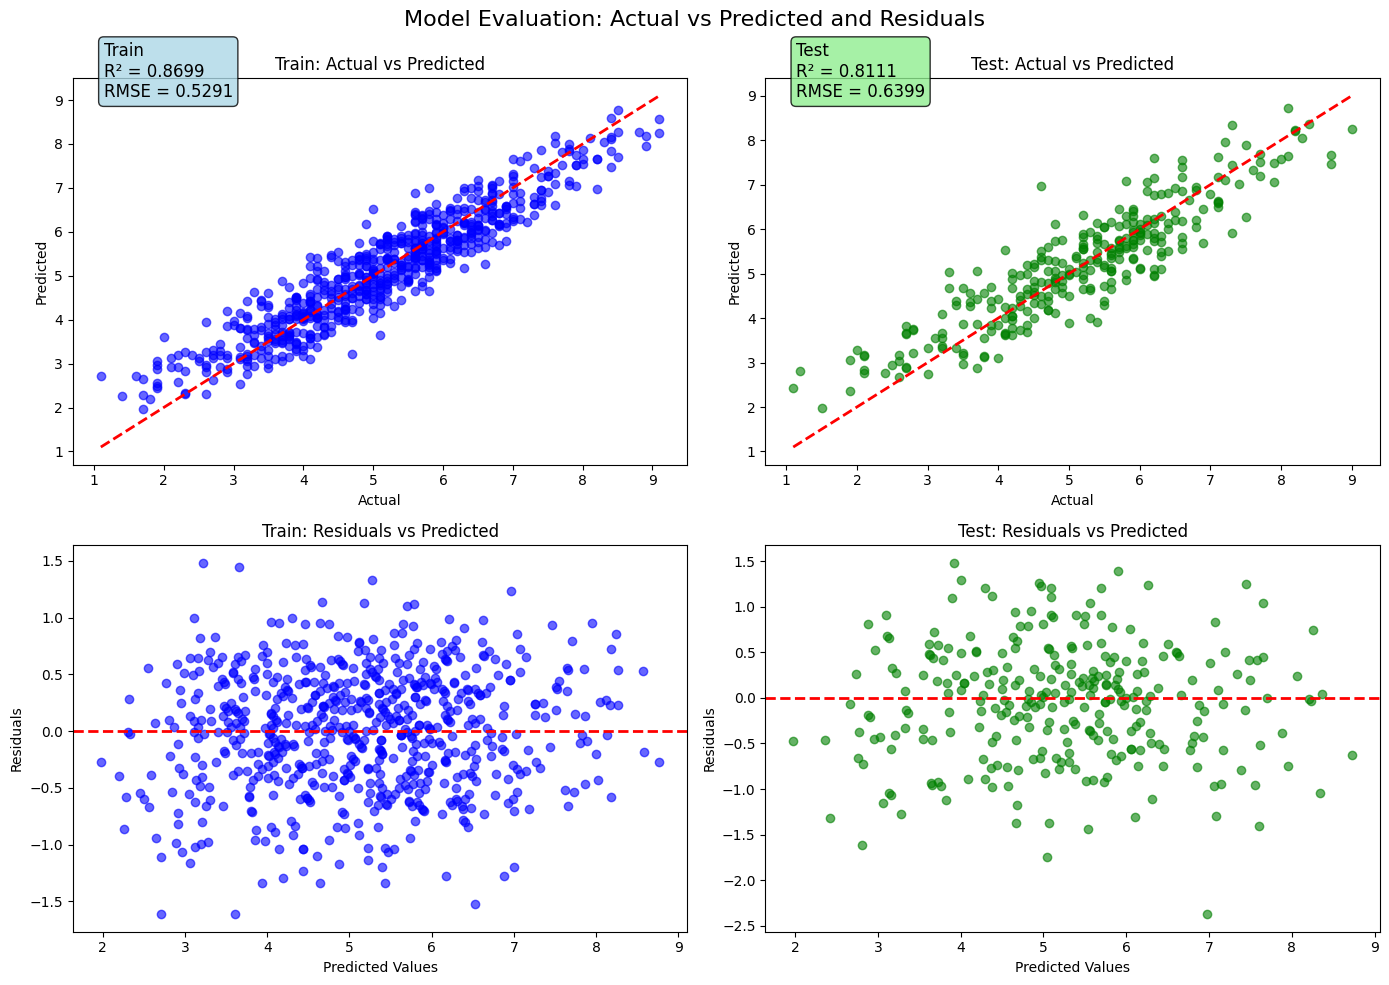

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# Metrics
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Create subplots: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Evaluation: Actual vs Predicted and Residuals', fontsize=16)

# -----------------------------------------
# 1. Actual vs Predicted (Train)
# -----------------------------------------
axes[0, 0].scatter(Y_train, Y_train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title('Train: Actual vs Predicted')
# Add metrics
axes[0, 0].text(0.05, 0.95, f'Train\nR² = {r2_train:.4f}\nRMSE = {rmse_train:.4f}',
                transform=axes[0, 0].transAxes, fontsize=12,
                bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))

# -----------------------------------------
# 2. Actual vs Predicted (Test)
# -----------------------------------------
axes[0, 1].scatter(Y_test, Y_test_pred, alpha=0.6, color='green')
axes[0, 1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title('Test: Actual vs Predicted')
# Add metrics
axes[0, 1].text(0.05, 0.95, f'Test\nR² = {r2_test:.4f}\nRMSE = {rmse_test:.4f}',
                transform=axes[0, 1].transAxes, fontsize=12,
                bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.8))

# -----------------------------------------
# 3. Residual Plot (Train)
# -----------------------------------------
residuals_train = Y_train - Y_train_pred
axes[1, 0].scatter(Y_train_pred, residuals_train, alpha=0.6, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Train: Residuals vs Predicted')

# -----------------------------------------
# 4. Residual Plot (Test)
# -----------------------------------------
residuals_test = Y_test - Y_test_pred
axes[1, 1].scatter(Y_test_pred, residuals_test, alpha=0.6, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Test: Residuals vs Predicted')

# Final layout
plt.tight_layout()
plt.show()

# Model Explanation with XAI


**SHAP**

![shap](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/shap.png?raw=1)

**Prompt:**

I trained an xgboost model. Features are 'Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration'. Using Shap, give me the code for feature importance plot and dependency plots.

Model name: best_model, use X_train data


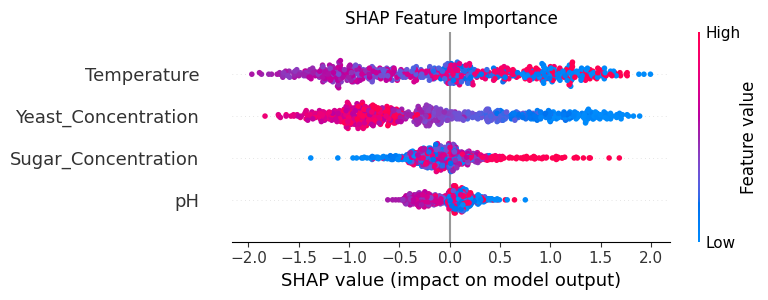

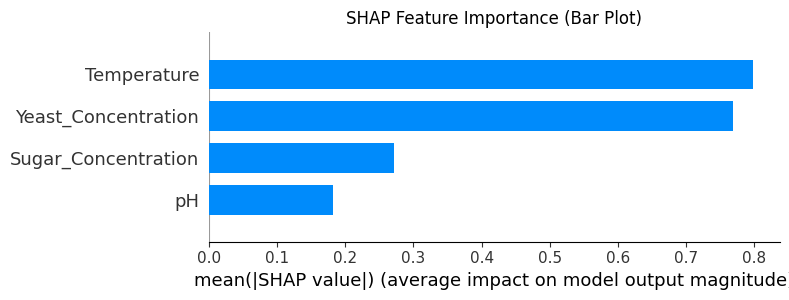

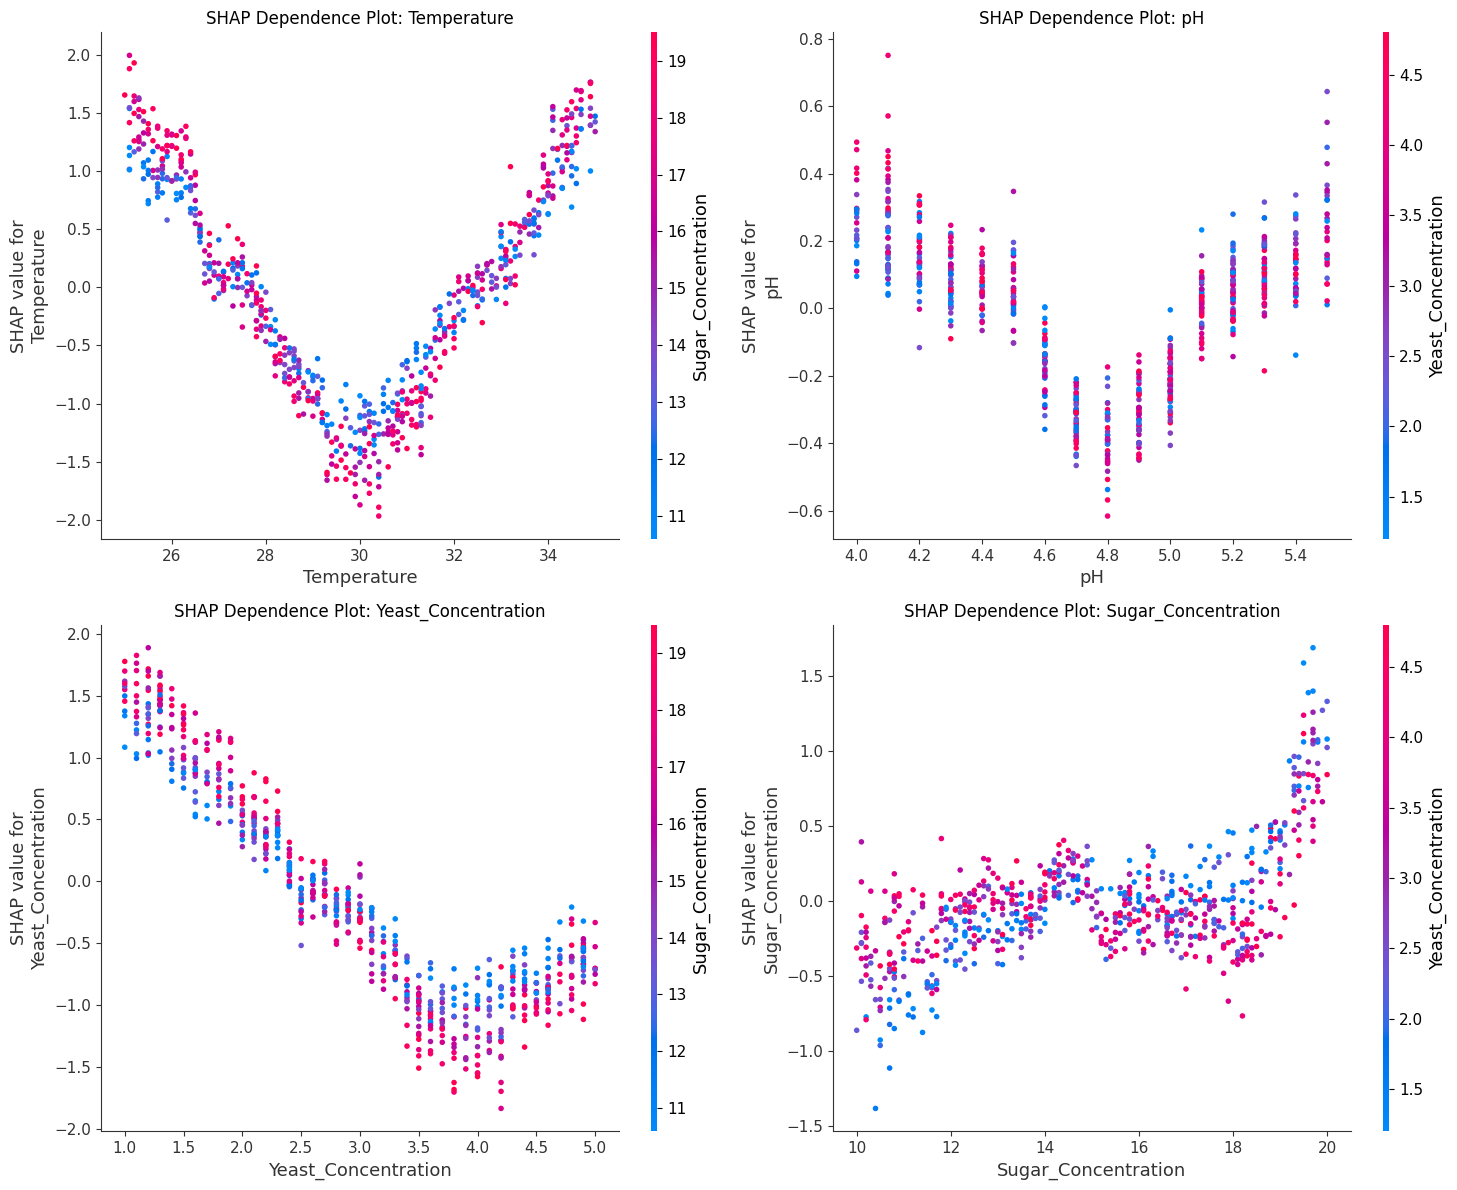

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np

# Load the data
url = 'https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv'
df = pd.read_csv(url)

# Define Y variable and features
y_variable = 'Residual_Sugar'
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']

# Remove rows with NaN values
df_clean = df[[y_variable] + features].dropna()

# Separate features (X) and target (y)
X = df_clean[features]
y = df_clean[y_variable]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost model
best_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
best_model.fit(X_train, y_train)

# Create SHAP explainer using the best_model and training data
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# 1. Feature Importance Plot (Summary Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=features, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# 2. SHAP Bar Plot (Feature Importance as Bar Chart)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features, show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

# 3. Dependency Plots for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(features):
    shap.dependence_plot(i, shap_values.values, X_train, feature_names=features, ax=axes[i], show=False)
    axes[i].set_title(f'SHAP Dependence Plot: {feature}')

plt.tight_layout()
plt.show()

# Optimization

![opt](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/optimization.jpg?raw=1)

**Stage 1 – Wide search (cheap, covers space)**

- Coarse grid
- Random search
- Few iterations of BayesOpt

Select top candidates:
- Sort results by predicted Residual_Sugar
- Pick top N
- Ensure they are not clustered (can use a distance filter)

**Stage 2 – Multiple BayesOpt refinements**

For each candidate:

- Define a local search box ±δ around its values
- Run a narrow Bayesian optimization in that box

Compare the refined minima from each candidate and pick the overall best.

**Prompt:**
Using two stage optimization (multicandidate for wide and Bayesian for narrow), find the optimum feature values to minimize target..features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration'] target = 'Residual_Sugar'

Parameter range:
    'Temperature': 25 to 35°C
    'pH': 4.0 to 5.5
    'Yeast_Concentration': 1 to 5 g/L
    'Sugar_Concentration': 10 to 20% w/v

In [10]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import pandas as pd

# Define the objective function to minimize (using the trained model)
def objective_function(params, model, features):
    # Ensure params is a numpy array
    params = np.array(params)
    # The model expects a 2D array (even for a single sample)
    input_data = params.reshape(1, -1)
    # Predict the residual sugar using the trained model
    predicted_residual_sugar = model.predict(input_data)[0]
    return predicted_residual_sugar

# Define the bounds for each feature based on the problem description
bounds = [
    (25, 35),  # Temperature
    (4.0, 5.5),  # pH
    (1, 5),  # Yeast_Concentration
    (10, 20)   # Sugar_Concentration
]

# --- Stage 1: Wide Search (Multicandidate) ---
# Using random sampling for simplicity in the wide search
n_candidates = 1000 # Number of random candidates for wide search
candidate_solutions = []
candidate_objectives = []

for _ in range(n_candidates):
    # Generate random parameters within bounds
    random_params = [np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(len(features))]
    # Calculate the objective for the random parameters
    obj_value = objective_function(random_params, best_model, features)
    candidate_solutions.append(random_params)
    candidate_objectives.append(obj_value)

# Select top N candidates (e.g., top 10) based on minimum objective value
top_n = 10
top_candidate_indices = np.argsort(candidate_objectives)[:top_n]
top_candidates = [candidate_solutions[i] for i in top_candidate_indices]

print(f"--- Stage 1: Wide Search (Random Sampling) ---")
print(f"Generated {n_candidates} candidates.")
print(f"Top {top_n} candidates and their predicted Residual Sugar:")
for i, idx in enumerate(top_candidate_indices):
    print(f"  Candidate {i+1}: {top_candidates[i]}, Predicted Residual Sugar: {candidate_objectives[idx]:.4f}")


# --- Stage 2: Multiple BayesOpt Refinements (Narrow Search) ---
print("\n--- Stage 2: Bayesian Optimization Refinements ---")

refined_solutions = []
refined_objectives = []

# Define Bayesian Optimization function (simplified for demonstration)
def bayesian_optimization_step(objective_func, bounds, n_iter=20):
    # Initialize Gaussian Process
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Simple initial sampling (can be improved)
    X_sample = np.array([np.random.uniform(b[0], b[1], size=n_iter) for b in bounds]).T
    Y_sample = np.array([objective_func(x, best_model, features) for x in X_sample])

    # Fit GP model
    gp.fit(X_sample, Y_sample)

    # Find the next point to sample (using acquisition function - here, just minimize GP mean)
    # More sophisticated acquisition functions (e.g., Expected Improvement) are typically used
    def acquisition(x):
        return gp.predict(np.array(x).reshape(1, -1), return_std=False)[0]

    # Minimize the acquisition function (using standard optimization)
    res = minimize(acquisition, X_sample[np.argmin(Y_sample)], bounds=bounds, method='L-BFGS-B')

    return res.x, res.fun

# Refine each top candidate
for i, candidate in enumerate(top_candidates):
    print(f"\nRefining Candidate {i+1}...")

    # Define local bounds around the candidate (adjust delta as needed)
    delta = [(b[1] - b[0]) * 0.1 for b in bounds] # 10% range around candidate
    local_bounds = [(max(bounds[j][0], candidate[j] - delta[j]), min(bounds[j][1], candidate[j] + delta[j])) for j in range(len(bounds))]

    try:
        refined_solution, refined_objective = bayesian_optimization_step(objective_function, local_bounds, n_iter=30) # More iterations for refinement
        refined_solutions.append(refined_solution)
        refined_objectives.append(refined_objective)
        print(f"  Refined Solution: {refined_solution}, Predicted Residual Sugar: {refined_objective:.4f}")
    except Exception as e:
        print(f"  Optimization failed for candidate {i+1}: {e}")
        # Optionally append the original candidate if refinement fails
        refined_solutions.append(candidate)
        refined_objectives.append(objective_function(candidate, best_model, features))


# --- Find the overall best refined solution ---
if refined_objectives:
    best_refined_index = np.argmin(refined_objectives)
    overall_best_solution = refined_solutions[best_refined_index]
    overall_best_objective = refined_objectives[best_refined_index]

    print("\n--- Overall Best Optimized Solution ---")
    print(f"Optimal Feature Values: Temperature={overall_best_solution[0]:.2f}°C, pH={overall_best_solution[1]:.2f}, Yeast_Concentration={overall_best_solution[2]:.2f} g/L, Sugar_Concentration={overall_best_solution[3]:.2f}% w/v")
    print(f"Minimum Predicted Residual Sugar: {overall_best_objective:.4f} g/L")
else:
    print("\nOptimization failed to produce any refined solutions.")

--- Stage 1: Wide Search (Random Sampling) ---
Generated 1000 candidates.
Top 10 candidates and their predicted Residual Sugar:
  Candidate 1: [29.481445927501905, 5.090986145620157, 4.261171098539688, 17.18061173672246], Predicted Residual Sugar: 1.4203
  Candidate 2: [29.439866518705742, 4.906737839392488, 3.5219443083170647, 17.807894837060605], Predicted Residual Sugar: 1.4803
  Candidate 3: [29.47840525295593, 4.702487193752686, 3.8890119112021204, 17.1868302601845], Predicted Residual Sugar: 1.5355
  Candidate 4: [29.428658396136775, 4.512212294947567, 4.2218261984327174, 17.063670986562276], Predicted Residual Sugar: 1.6682
  Candidate 5: [30.020596258624728, 5.273872041879386, 3.926955207863228, 17.39111982601603], Predicted Residual Sugar: 1.6854
  Candidate 6: [30.344089577377396, 4.922574914250032, 3.792940833368157, 16.906729332041728], Predicted Residual Sugar: 1.6951
  Candidate 7: [30.031304323464457, 5.008795675789752, 3.833782208671375, 15.97159110446125], Predicted Re

In [ ]:
!pip install shap